In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import utils
import pointcloud_analysis as pa
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Networks and Embedding

In [2]:
class myNet(nn.Module):
    
    def __init__(self,tr_size = 3):
        super().__init__()
        hidden = 3
        self.fc2 = nn.Linear(tr_size, tr_size,bias=False)

    def forward(self, x):
        x = self.fc2(x) # Transformation
        return x
    
class myNetEmbedding(nn.Module):
    
    def __init__(self):
        super().__init__()

    def forward(self, x):

        return x
embedding = myNetEmbedding()

# Get Data

In [3]:
# setting

# Please choose a value N
N = 12

number_known = N
seed = 0

# create data
pointso, points2o, unknown_weight, losses = pa.create_online_data(N)
print(points2o.shape)

tensor(-1.0000)
torch.Size([12, 3])


## Plot Data

Only for 3D data


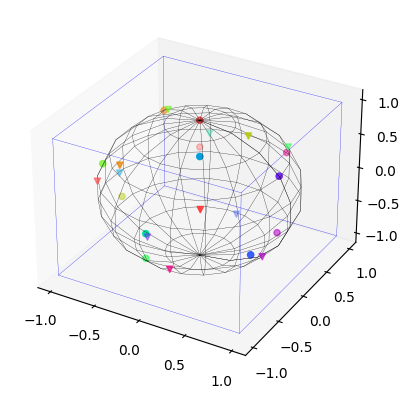

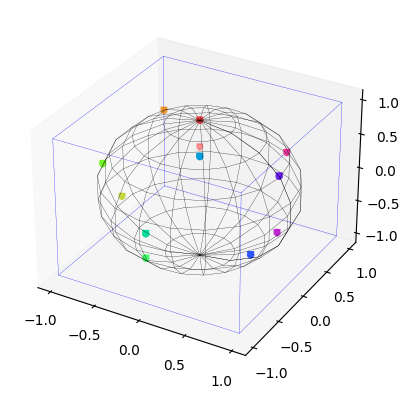

In [4]:
%matplotlib inline
print("Only for 3D data")
if points2o.shape[1] == 3:
    utils.plot_wireframe(pointso, points2o)
    utils.plot_wireframe(pointso, (torch.pinverse(unknown_weight).T@points2o.T).T)

## Permute Data

In [5]:
# get permutation
randpermutation = torch.randperm(N)

# apply permutation to points
points2 = points2o
points = pointso[randpermutation]

# check true reconstruction
true_p2 = points2@torch.pinverse(unknown_weight)

# create and permute labels
labels, trueIndices = pa.create_labels(N, number_known, seed)
labels = labels[randpermutation]
trueIndices = trueIndices[randpermutation]

## Plot permuted Data

Only for 3D data


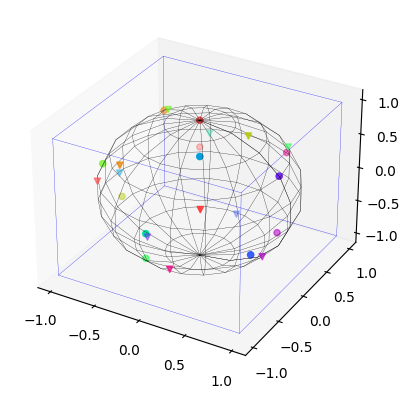

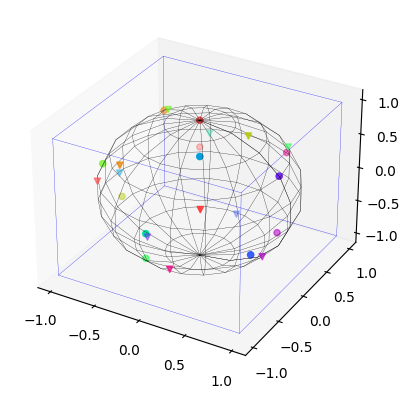

In [6]:
%matplotlib inline
print("Only for 3D data")
inverse_randpermutation = np.argsort(randpermutation)
if points2.shape[1] == 3:
    utils.plot_wireframe(points[inverse_randpermutation], points2)
    utils.plot_wireframe(pointso, points2o)

# Optimize

ReLU Experiment: 
- loss = "relu"
- alpha = 0.5
- epochs = 12000
- lr = 0.01
- increase_alpha = 0
- opt = "Adam"
- stoch = 0

Softmax Experiment:
- loss = "softmax"
- alpha = 100
- epochs = 12000
- lr = 0.01
- increase_alpha = 1
- opt = "Adam"
- stoch = 1

In [7]:
loss = "softmax"
alpha = 1000
epochs = 20000
lr = 0.01
increase_alpha = 1
opt = "Adam"
stoch = 0

Load and preset model

In [8]:
model = myNet(tr_size=points2.shape[1])

Train and evaluate model

In [9]:
# train modelimport torch.profiler

trainedModel, embedding, losses = pa.train_model(points, points2, model, embedding, labels, lr, \
                                                    stoch, epochs,alpha, increase_alpha, loss, opt, seed = seed, device = 'cuda')

# validate model
df, PABloss = pa.validate_model(trainedModel, embedding, points, points2, trueIndices, losses, alpha, setting = None, 
                                id=0, loss_str=loss, permutedinput=inverse_randpermutation)
df

100%|██████████| 20000/20000 [00:22<00:00, 908.99it/s, loss=0]     


,position,point_distance,binary,newloss,id
0,0.0,0.056719,0,0.0,0


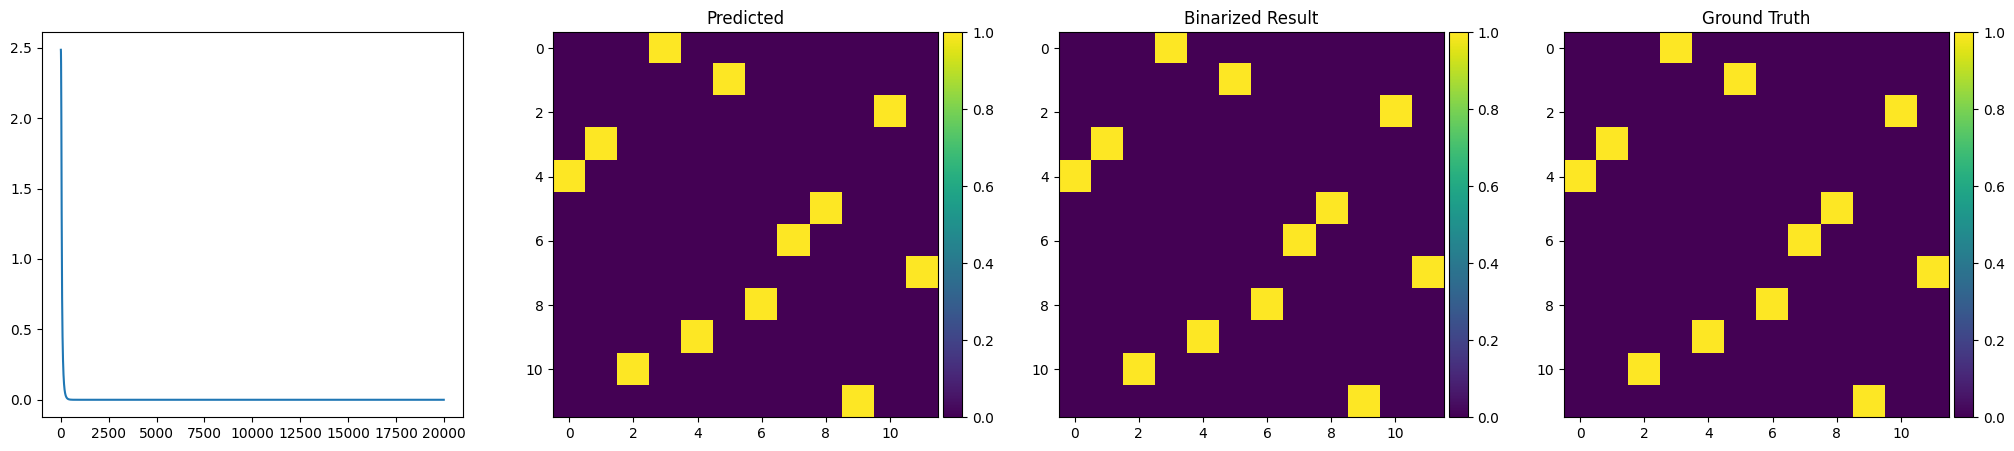

In [10]:
try:
    %matplotlib qt
except:
    %matplotlib inline


fig = plt.figure(figsize=(25,5))
norm = lambda pred: pred / torch.sqrt(torch.sum(pred**2,dim=1))[:,None]

# plot loss
ax = fig.add_subplot(1, 4, 1)
ax.plot(losses)

# plot permutation
ax = fig.add_subplot(1, 4, 2)
ax.set_title("Predicted")
im1=ax.imshow(PABloss["perm"])
# im1=ax.imshow(torch.exp(PABloss["perm"]))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

# plot permutation
ax = fig.add_subplot(1, 4, 4)
ax.set_title("Ground Truth")
im1=ax.imshow(torch.nn.functional.one_hot(trueIndices))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

# plot points
armgmax = utils.argmax_matrix(torch.exp(PABloss["perm"]))
ax = fig.add_subplot(1, 4, 3)
ax.set_title("Binarized Result")
im1=ax.imshow(armgmax)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

plt.show()
